# Simple Example with map_partitions

LSDB/HATS catalogs are organized into partitions, and this number of partitions is reported as `npartitions=` in the header, whenever printing a catalog.

This can be used to distribute operations across the catalog with maximum efficiency.

In [29]:
# Dask puts out more advisory logging that we care for.
# It takes some doing to quiet all of it, but this recipe works.

import dask

dask.config.set({"logging.distributed": "critical"})

# This also has to be done, for the above to be effective
logger = logging.getLogger("distributed")
logger.setLevel(logging.CRITICAL)

import warnings

# Finally, suppress the specific warning about Dask dashboard port usage
warnings.filterwarnings("ignore", message="Port 8787 is already in use.")

In [2]:
import lsdb

gaia_root = "https://data.lsdb.io/hats"
gaia3 = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    search_filter=lsdb.ConeSearch(ra=280, dec=-60, radius_arcsec=2 * 3600),
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
    ],
)
gaia3

,source_id,ra,dec,phot_g_mean_mag
npartitions=4,,,,
"Order: 4, Pixel: 2944",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 2945",...,...,...,...
"Order: 4, Pixel: 2946",...,...,...,...
"Order: 4, Pixel: 2947",...,...,...,...


In [3]:
# You can get the number of partitions programmatically this way.
# This can be valuable when you want to choose the optimal number
# of workers to process the partitions.
len(gaia3.get_healpix_pixels())

4

In [4]:
# The individual elements of that list are HealpixPixel objects whose order
# and pixel you can inspect, if desired.
px = gaia3.get_healpix_pixels()[0]
px.order, px.pixel

(np.int64(4), np.int64(2944))

## Generating New Columns

Since the partition's `DataFrame` is passed in to you, you can augment it with new columns based on the existing columns, in ordinary Pandas style.

### What you can map

The trick is understanding what kind of function you can pass to `.map_partitions`.  Your function is going to receive a Pandas DataFrame as its first parameter.  Other parameters can be passed in as keyword arguments to `.map_partitions`, as you'll see later on.  For now, we'll use a function that takes in one partition and produces a result that has the same shape.

Because the catalog is loaded lazily, `.map_partitions` also returns a lazy, or unevaluated, result.  You can realize it by either calling `.compute()` (to produce a `DataFrame` in memory) or `.to_hats()` (to serialize it to disk as a HATS-format file).

In [5]:
def mean_sq(df, pixel):
    df["phot_g_mean_mag_sq"] = df["phot_g_mean_mag"] ** 2
    return df


unrealized = gaia3.map_partitions(mean_sq, include_pixel=True)
unrealized

,source_id,ra,dec,phot_g_mean_mag,phot_g_mean_mag_sq
npartitions=4,,,,,
"Order: 4, Pixel: 2944",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 2945",...,...,...,...,...
"Order: 4, Pixel: 2946",...,...,...,...,...
"Order: 4, Pixel: 2947",...,...,...,...,...


This unrealized result has a top-level property indicating how many partitions it has.  We can use this to choose our number of workers directly.

However, it's a good idea to bound the number of workers, in case the number of partitions is larger that we expect (or we move this code fragment elsewhere).

In [6]:
%%time
npartitions = len(gaia3.get_healpix_pixels())
from dask.distributed import Client

with Client(n_workers=min(8, npartitions)) as client:
    result = unrealized.compute()
result

CPU times: user 1.24 s, sys: 178 ms, total: 1.42 s
Wall time: 10 s


,source_id,ra,dec,phot_g_mean_mag,phot_g_mean_mag_sq
_healpix_29,,,,,
3315212135629220059,6630424242158614528,279.475941,-61.973682,20.157476,406.323839
3315212197603296958,6630424379597543936,279.40738,-61.977054,19.488537,379.803074
...,...,...,...,...,...
3318663093295462547,6637326190180387584,280.426265,-58.015067,21.097507,445.104802
3318663093808668415,6637326185883831296,280.423503,-58.013744,20.301455,412.149075


No reduction step is needed here since the operation is not a reducing operation.
There are as many rows in the new output as there were in the input.

## Functions that reduce

The above works when your output rows are the same as your input rows.  When you're doing a reducing operation (such as calculating statistics), the process changes a little.

## What you can map

### Your function's parameters

Again, your first input parameter is a `pd.DataFrame` that is one partition of the catalog, and the return value of your function needs to be the same, even if your result has only a single row.

If you want to know the HEALPix number of the partition, calling `.map_partitions` with `include_pixel=True` will pass that as the second parameter to your function.  We'll do this in this example, for demonstration purposes, though it isn't strictly necessary to this task.

If you have any other parameters that your function requires, take them as keyword arguments, and you can pass their values in as such, when calling `.map_partitions`.  Our example will do this, too, taking a `target_column=` argument.

## What you get back

The operation we're going to do here is a reducing operation (min and max), and it will be run on each partition, reducing the many rows in each partition to a single value.  This means that the output of `.map_partitions` in this case will contain *one row per partition*.  Thus, you will need to do additional reduction on this output in order to get a single final result.

In [7]:
# Given a target column, produce a DataFrame that has nothing but
# the min and max values for that column.
#
# Note that the function must work correctly when given an empty DataFrame
# as an input, too; if not, you're obliged to provide "meta", that is,
# information about argument type and shape.  It's certainly easier to
# simply handle DataFrames when you can.
import pandas as pd


def find_stats(df, pixel, target_column=""):
    min_val = df[target_column].min()
    max_val = df[target_column].max()
    return pd.DataFrame(
        [
            {
                "pixel": pixel,
                f"{target_column}_min": min_val,
                f"{target_column}_max": max_val,
            }
        ]
    )

In [8]:
unrealized = gaia3.map_partitions(
    find_stats,
    include_pixel=True,
    # Keyword arguments after 'include_pixel=' are passed to your function.
    target_column="phot_g_mean_mag",
)

In [9]:
%%time
npartitions = len(gaia3.get_healpix_pixels())
from dask.distributed import Client

with Client(n_workers=min(8, npartitions)) as client:
    result = unrealized.compute()
result

CPU times: user 467 ms, sys: 83.1 ms, total: 550 ms
Wall time: 8.81 s


,pixel,phot_g_mean_mag_min,phot_g_mean_mag_max
0,"Order: 4, Pixel: 2944",8.154537,22.033451
0,"Order: 4, Pixel: 2945",5.508409,22.345750
0,"Order: 4, Pixel: 2946",6.264917,22.076380
0,"Order: 4, Pixel: 2947",6.154421,21.986425


The objects in the 'pixel' column are the same type as from `get_healpix_pixels()`.

In [10]:
type(result["pixel"].iloc[0])

hats.pixel_math.healpix_pixel.HealpixPixel

Because the result is one row per partition, we need additional reduction to get our single answer.

In [11]:
result["phot_g_mean_mag_min"].min(), result["phot_g_mean_mag_max"].max()

(5.508409, 22.34575)

What about searching not only the four partitions from our cone search, but the whole catalog?  All that changes is the number of partitions.

In [12]:
gaia3_all = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
    ],
)
unrealized = gaia3_all.map_partitions(
    find_stats,
    include_pixel=True,
    # Keyword arguments after 'include_pixel=' are passed to your
    # function
    target_column="phot_g_mean_mag",
)
npartitions = len(unrealized.get_healpix_pixels())

In [13]:
npartitions

3933

That's a lot of partitions!  If we didn't bound this value, we could easily overwhelm our cluster.

This operation is light on compute, so let's give each worker several threads.

In [14]:
%%time
with Client(n_workers=min(8, npartitions), threads_per_worker=4) as client:
    result = unrealized.compute()
result

2025-03-18 22:27:52,086 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/opt

CPU times: user 1min 27s, sys: 6.64 s, total: 1min 34s
Wall time: 7min 8s


,pixel,phot_g_mean_mag_min,phot_g_mean_mag_max
0,"Order: 2, Pixel: 0",3.382374,22.452248
0,"Order: 3, Pixel: 4",3.836123,22.281105
...,...,...,...
0,"Order: 4, Pixel: 3067",6.026669,22.432905
0,"Order: 3, Pixel: 767",3.449377,22.423697


In [15]:
# We need to do a final reduction step to get the true min and max
result["phot_g_mean_mag_min"].min(), result["phot_g_mean_mag_max"].max()

(1.731607, 22.956425)

Since we just searched the whole catalog, we can check our answer
against the statistics that were compiled at import time for the
catalog.  As you can see, they match what we got when using
the `.map_partitions` method.

In [16]:
gaia3_all.hc_structure.aggregate_column_statistics(include_columns="phot_g_mean_mag")

,min_value,max_value,null_count
column_names,,,
phot_g_mean_mag,1.731607,22.956425,5455339.0


## Histograms

Here's another example that requires a reduction and a change
in data shape.

Suppose we want to bin observations by magnitude in the G band.
We'll need to load different columns than before,
since we didn't include observations earlier.

This is more involved than the straightforward `pd.DataFrame.hist`
because each row contains some number of observations, and we want
to sum these observations within each magnitude bin.

In [17]:
import lsdb

gaia3 = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    search_filter=lsdb.ConeSearch(ra=280, dec=-60, radius_arcsec=2 * 3600),
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_g_n_obs",
    ],
)
gaia3

,source_id,ra,dec,phot_g_mean_mag,phot_g_n_obs
npartitions=4,,,,,
"Order: 4, Pixel: 2944",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow]
"Order: 4, Pixel: 2945",...,...,...,...,...
"Order: 4, Pixel: 2946",...,...,...,...,...
"Order: 4, Pixel: 2947",...,...,...,...,...


### All Within Memory

First, what does it look like to do it all within memory?

In [18]:
%%time
df = gaia3.compute()
df

CPU times: user 988 ms, sys: 381 ms, total: 1.37 s
Wall time: 4.36 s


,source_id,ra,dec,phot_g_mean_mag,phot_g_n_obs
_healpix_29,,,,,
3315212135629220059,6630424242158614528,279.475941,-61.973682,20.157476,298
3315212197603296958,6630424379597543936,279.40738,-61.977054,19.488537,346
...,...,...,...,...,...
3318663093295462547,6637326190180387584,280.426265,-58.015067,21.097507,42
3318663093808668415,6637326185883831296,280.423503,-58.013744,20.301455,336


Note that the four partitions become over 450k rows once they are computed.  The lazily-loaded
catalog can't show you how many total rows there are before computing, only the number of
partitions.

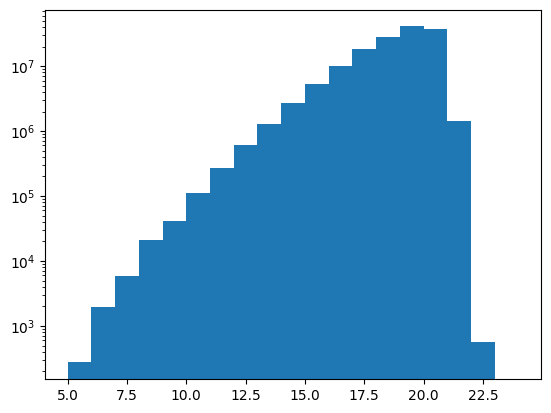

In [19]:
from matplotlib import pyplot as plt

mag_bins = list(range(5, 25, 1))
plt.hist(df["phot_g_mean_mag"], bins=mag_bins, weights=df["phot_g_n_obs"])
plt.yscale("log")

This is a small enough amount of data that it's easy to handle it
in-memory.  But we wouldn't be able to do this on the whole Gaia3
catalog.  For that, we'll need to use `.map_partitions`, and we'll
test this function on the same small piece of data before launching
it across the entire catalog.

The first step is to understand that we'll be creating partial histograms,
that is, a histogram for each partition, and we'll need to reduce those
down to a single histogram at the end.  One consequence of this is
the need to have the same number of bins in each partial histogram,
`mag_bins` in this case.  Often when producing a histogram, it's common
to let Pandas or `pd.cut` pick the bin boundaries given a number of
bins, but that will work against us in this case, since each partition
will have a different min and max, and the partial histograms won't
reduce.

In [20]:
# This function only requires and returns one DataFrame: no pixel
# argument, no additional arguments.
def observation_histogram(df):
    df["binned"] = pd.cut(df["phot_g_mean_mag"], mag_bins)
    binned_data = df.groupby("binned", observed=True)["phot_g_n_obs"].sum()
    return binned_data

First, we test our new function on our single in-memory `DataFrame`, to
see that we get the results we expect.

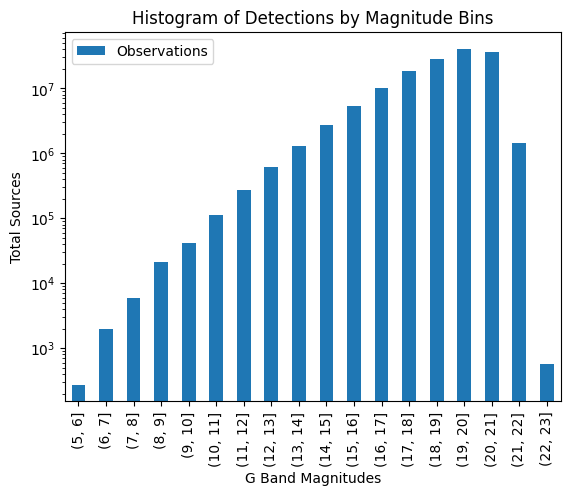

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

bd = observation_histogram(df)

bd.plot(kind="bar", ax=ax, label="Observations")

ax.set_title("Histogram of Detections by Magnitude Bins")
ax.set_xlabel("G Band Magnitudes")
ax.set_ylabel("Total Sources")

ax.legend()
ax.set_yscale("log")

plt.show()

### Using map_partitions

The above went pretty quickly, because our cone search is keeping our data small.
But if it were a much larger slice of the sky, this next technique would matter
more.

As before, `.map_partitions` will give us one result per partition, so we need
to be prepared to do a final combination step.

In [22]:
unrealized = gaia3.map_partitions(observation_histogram)
unrealized

/home/dtj1s/.local/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:303: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


Dask Series Structure:
npartitions=4
3314649325744685056    int64[pyarrow]
3315775225651527680               ...
3316901125558370304               ...
3318027025465212928               ...
3319152925372055552               ...
Dask Name: observation_histogram, 6 expressions
Expr=MapPartitions(observation_histogram)

In [23]:
unrealized.npartitions

4

In [24]:
%%time
from dask.distributed import Client

with Client(n_workers=unrealized.npartitions) as client:
    result = unrealized.compute()
# This is actually the histogram repeated for each partition.
pd.DataFrame({"binned": result})

CPU times: user 437 ms, sys: 66 ms, total: 503 ms
Wall time: 9.15 s


,binned
binned,
"(8, 9]",2811
"(9, 10]",4784
...,...
"(20, 21]",11124220
"(21, 22]",493954


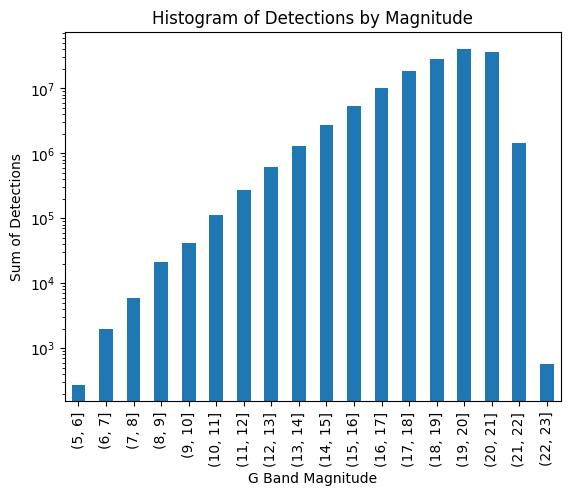

In [25]:
# Final reduction step
total_histogram = result.groupby("binned", observed=True).sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
total_histogram.plot(kind="bar", ax=ax)
ax.set_title("Histogram of Detections by Magnitude")
ax.set_xlabel("G Band Magnitude")
ax.set_ylabel("Sum of Detections")
ax.set_yscale("log")
plt.show()

And now compare the result and timing to running this histogram on
the entire catalog.

In [26]:
gaia3 = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_g_n_obs",
    ],
)
unrealized = gaia3.map_partitions(observation_histogram)
unrealized

/home/dtj1s/.local/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:303: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


Dask Series Structure:
npartitions=3933
0                      int64[pyarrow]
18014398509481984                 ...
                            ...      
3454260914193170432               ...
3458764513820540928               ...
Dask Name: observation_histogram, 4 expressions
Expr=MapPartitions(observation_histogram)

In [27]:
%%time
from dask.distributed import Client

# Takes 8-10 minutes
with Client(n_workers=min(8, unrealized.npartitions), threads_per_worker=4) as client:
    result = unrealized.compute()
# This is actually the histogram repeated for each partition.
pd.DataFrame({"binned": result})

2025-03-18 22:37:23,868 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/opt

CPU times: user 1min 37s, sys: 8.44 s, total: 1min 45s
Wall time: 9min 3s


,binned
binned,
"(5, 6]",3297
"(6, 7]",7250
...,...
"(21, 22]",4548691
"(22, 23]",7823


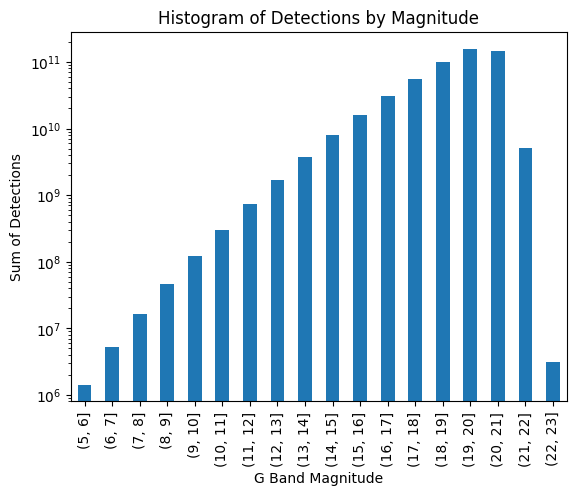

In [28]:
# Final reduction
total_histogram = result.groupby("binned", observed=True).sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
total_histogram.plot(kind="bar", ax=ax)
ax.set_title("Histogram of Detections by Magnitude")
ax.set_xlabel("G Band Magnitude")
ax.set_ylabel("Sum of Detections")
ax.set_yscale("log")
plt.show()

The histogram has the same shape but a different Y-axis, as is reasonable:
our small cone search had picked a part of the sky which was representative
of the whole, but processing the entire catalog increased the number
of observations across all bins.